2 MULTI-CLASSIFICATION avec Softmax

PREPARATION DES DONNEES:

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

c:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)
[[ 1.80828877  0.81093022  0.39       -0.10536052 -3.32423634  1.79175947
   2.7080502   0.99386     3.27       -0.75502258]]
[7 5 5 5 6 6 6 8 7 6 6 5 6 6 5 7 6 5 5 6 7 7 6 7 5 6 5 6 6 5 7 7 5 6 7 7 8
 6 5 6 6 5 5 5 5 6 4 7 6 5 5 5 7 5 6 5 5 7 4 5 4 5 7 5 6 7 6 6 5 6 6 6 7 6
 5 7 6 6 5 6 6 6 6 6 8 4 4 7 5 7 7 5 5 6 5 7 6 6 5 7 7 5 7 5 7 6 4 7 5 5 5
 4 6 4 6 7 6 5 5 6 5 5 7 7 5 5 6 7 6 7 6 5 6 5 6 7 5 6 7 5 4 6 6 5 8 7 7 5
 5 5 7 5 7 4 4 6 6 6 5 6 7 7 6 7 7 5 6 5 6 5 4 6 7 5 7 6 6 6 6 5 6 5 7 5 6
 7 6 6 7 5 7 7 6 5 7 7 6 7 7 6 7 5 5 6 6 6 6 5 7 5 5 4 6 6 7 7 5 7 7 5 6 5
 6 8 5 5 6 5 5 7 5 8 5 5 5 5 5 8 8 6 5 6 7 6 6 5 5 5 5 5 6 5 6 6 5 7 5 7 5
 5 7 7 5 5 6 5 6 6 5 7 5 4 7 6 5 6 5 4 6 6 7 7 6 6 5 6 6 6 6 5 7 5 6 5 7 5
 6 5 6 6 5 6 7 5 6 7 7 6 7 7 5 5 6 6 6 5 5 7 6 6 5 7 5 5 5 6 6 6 5 5 6 5 7
 5 6 6 6 6 7 6 5 8 5 6 5 6 7 7 5 7 5 8 5 6 7 6 6 5 6 5 7 6 6 5 5 6 5 4 6 8]
nombre d'observations X:  370
nombre d'observations y:  370
X_mu = [[ 0.12947268 -0.26406452  0.23977183

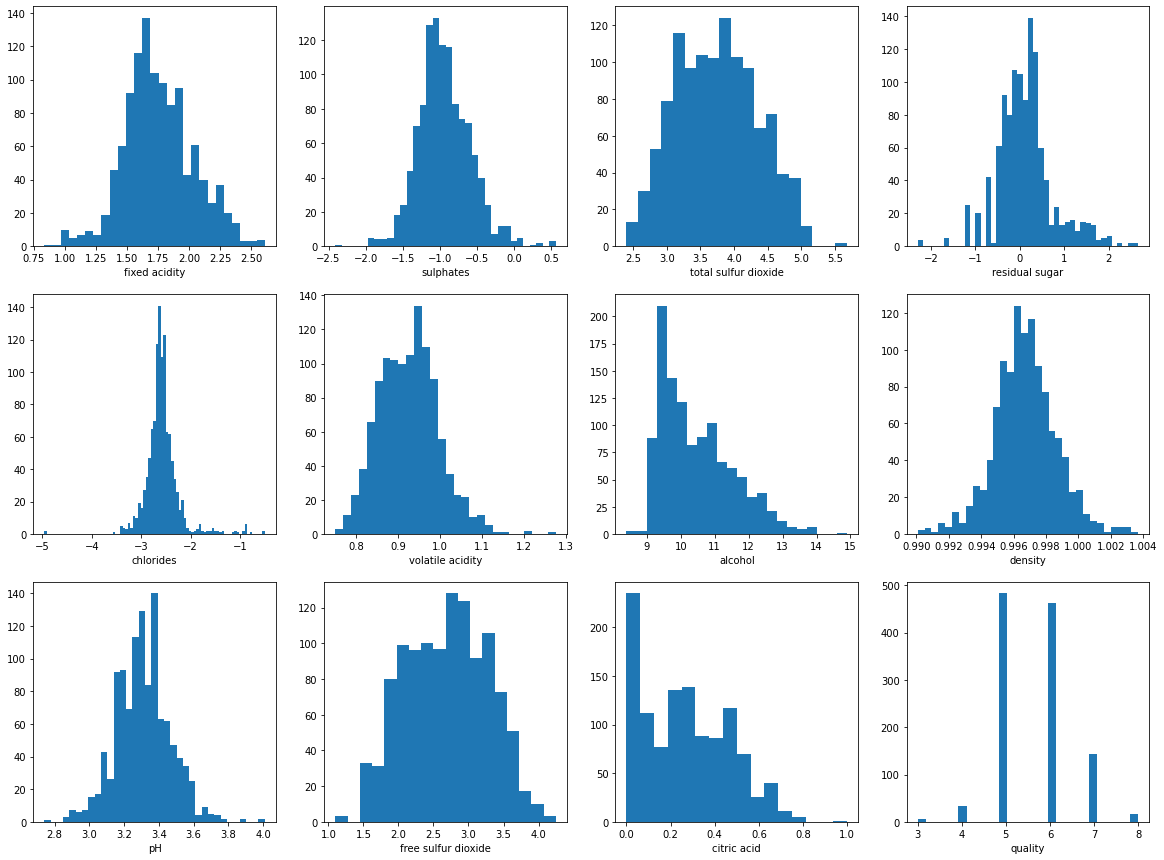

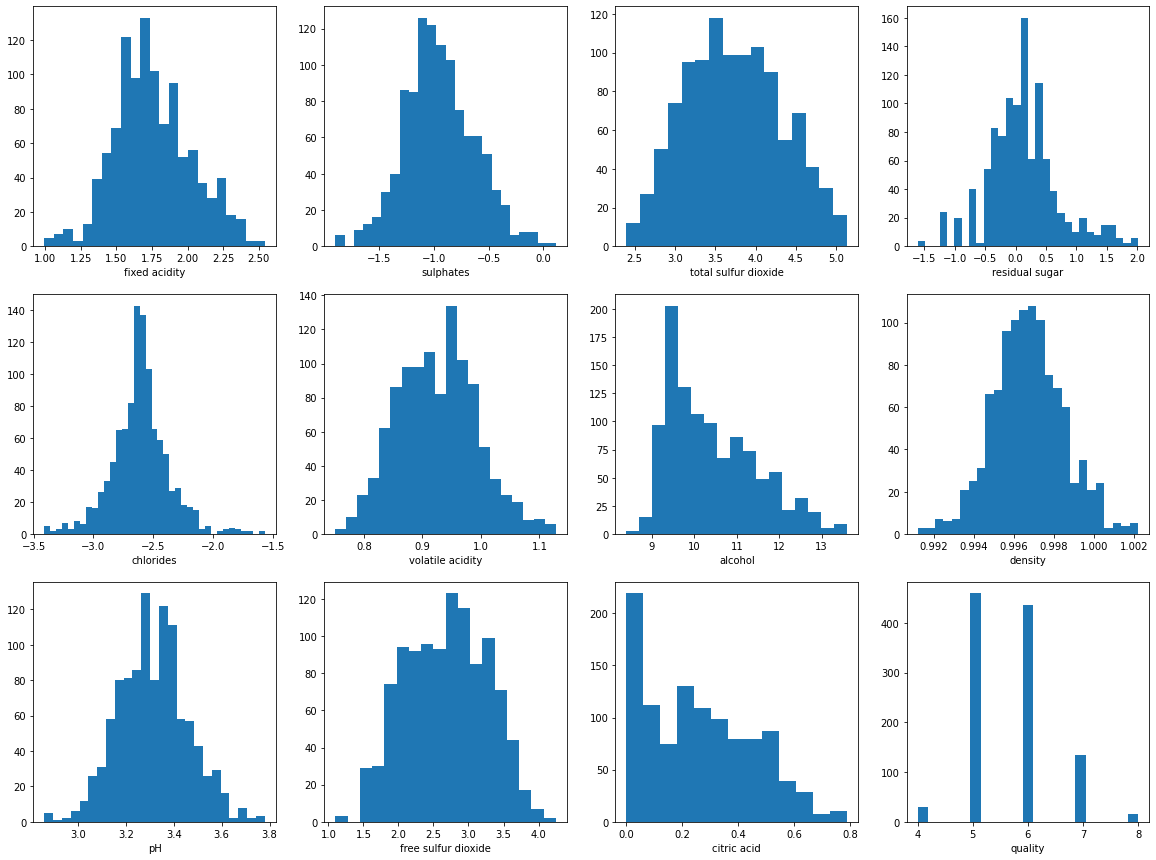

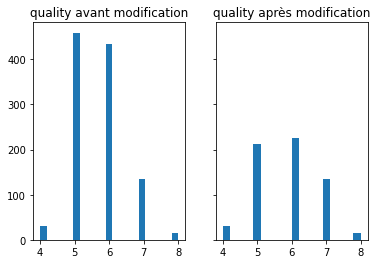

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

print(X_train[:1])
print(y_train)
print("nombre d'observations X: ",len(X_train))
print("nombre d'observations y: ",len(y_train))

def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
# normalize the features
X_train, X_tmu, X_tsigma = zscore_normalize_features(X_train)
X_cv, X_cmu, X_csigma = zscore_normalize_features(X_cv)
X_test, X_smu, X_ssigma = zscore_normalize_features(X_test)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

print("train : ",X_train.shape)
print("cv : ",X_cv.shape)
print("test : ",X_test.shape)


METHODE : Nous allons cette fois utiliser une descente de gradient, mais à la place de trouver des coefficients d'une régression linéaire prédisant une valeur de qualité continue, nous allons trouver les coefficients de 9 fonctions pour chaque valeur de qualité ( entre 0 et 8 ). Ces fonctions donnent pour une observation une probabilité d'appartenir à cette qualité. Une prédiction d'une observation X est donc la probabilité maximale d'appartenance à une classe de qualité. L'erreur correspond à la proportion d'observations X mal classées.

CODE :

In [67]:
import copy
import math

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g
    
def compute_cost_softmax(X, y, W, B):
    m, n = X.shape
    #print("n",n)
    nb_f=W.shape[0]
    #print("nf",nb_f)
   
    loss_sum = 0 

    
  # on calcule tous les zj=fwb
   # Loop over each training example
    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 

        f_WB[loop] = np.exp(z_wb)#=e(Zij), #à diviser par sumezi pour avoir probabilité que y==loop
      sumEzi=np.sum(f_WB)
      #print(sumEzi)
      loss_sum += np.log(f_WB[y[i]]/sumEzi) # on ajoute log(a_i) if y=i
      
    total_cost = -(1 / m) * loss_sum  #cost = -1/m(sum(sum{y==j}log(ezj/sum(ezk))))

    return total_cost


def compute_gradient_softmax(X, y, W, B): 


    m, n = X.shape
    nb_f=W.shape[0]

    dJ_DW = np.zeros((nb_f,n))                           #(n,)
    dJ_DB = np.zeros((nb_f))

    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 
        f_WB[loop] = np.exp(z_wb)#=e(Zij)

      sumEzi=np.sum(f_WB) 
      f_WB=f_WB/sumEzi # tableau des probabilité que y==loop

      #print("somme des f_WB : ",sum(f_WB))
      #on calcule la dérivé
      for loop in range(nb_f):
        err_loop  = f_WB[loop]  - (loop==y[i])         #scalar, proba que y = loop  - (1 ou 0)(si y ==loop)
        for j in range(n):
            dJ_DW[loop,j] = dJ_DW[loop,j] + err_loop * X[i,j]      #scalar
        #print("dJ_DW[loop,j]",dJ_DW[loop,j])
        dJ_DB[loop] = dJ_DB[loop] + err_loop
        #if(i==50):
        #  print("\n")
        #  print("y_i",y[i])
        #  print("y_loop",loop)
        #  print("fb",f_WB[loop])
        #  print("(loop==y[i]) ",(loop==y[i]) )
        #  print("err_loop",err_loop)
        #  print("dJ_DW[loop,j]",dJ_DW[loop,j])
    dJ_DW = dJ_DW/m                                   #(n,)
    dJ_DB = dJ_DB/m                                   #scalar
        
    return dJ_DB, dJ_DW 

def gradient_descent_softmax(X, y, W_in, B_in, alpha, num_iters): 

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    W = copy.deepcopy(W_in)  #avoid modifying global w within function
    B = B_in
    m, n = X.shape
    nb_f=W.shape[0]
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dJ_DB, dJ_DW = compute_gradient_softmax(X, y, W, B)   

        # Update Parameters using w, b, alpha and gradient
        W = W - alpha * dJ_DW               
        B = B - alpha * dJ_DB               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_softmax(X, y, W, B) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 30) == 0:
            
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
            #print("W : ",W," B : ",B)
            #x_test = X_train[50]   # example
            #print(x_test)
            #tabProbas=np.dot(W,x_test)+B
            #print(tabProbas)
            
    return W, B, J_history         #return final w,b and J history for graphing 

APPLICATION :

Choix de l'hyperparametre alpha entre alpha = {0.01;0.1;1}
On va utiliser pour cela la cross validation en entraîant sur X_train et en testant sur X_cv

In [74]:
nbClasses=9
np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
initial_B = np.ones(nbClasses)*0.5

# Gradient descent settings
iterations = 1000
alpha1 = 0.01 ; alpha2=0.1 ; alpha3=1

W,B, J_history = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha1, iterations)
W2,B2, J_history2 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha2, iterations)
W3,B3, J_history3 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha3, iterations)

print("W_alpha1 = ",W, " B_alpha1 = ",B)
print("W_alpha2 = ",W2, " B_alpha2 = ",B2)
print("W_alpha3 = ",W3, " B_alpha3 = ",B3)

Iteration    0: Cost 2.4400717695369334   
Iteration  100: Cost 2.0536004210152807   
Iteration  200: Cost 1.780485112593922   
Iteration  300: Cost 1.594407972095395   
Iteration  400: Cost 1.468678280902264   
Iteration  500: Cost 1.381564722260105   
Iteration  600: Cost 1.318621168347779   
Iteration  700: Cost 1.2711860725072572   
Iteration  800: Cost 1.2341535847452123   
Iteration  900: Cost 1.2044229288700883   
Iteration    0: Cost 2.399730124779944   
Iteration  100: Cost 1.1770347855725811   
Iteration  200: Cost 1.061684869178817   
Iteration  300: Cost 1.019618044967812   
Iteration  400: Cost 0.997681009646861   
Iteration  500: Cost 0.9841911101224723   
Iteration  600: Cost 0.975053943604602   
Iteration  700: Cost 0.9684545919046595   
Iteration  800: Cost 0.9634629762393693   
Iteration  900: Cost 0.9595533010117359   
Iteration    0: Cost 2.030211407230281   
Iteration  100: Cost 0.9558697786293144   
Iteration  200: Cost 0.941931067150108   
Iteration  300: Cost 0.

In [83]:
def predict_accuracy(X,y,W,B):
    yp = np.zeros(len(X))
    for loop in range(len(X)):
        tabProbas=np.dot(W,X[loop])+B
        tabProbas=sigmoid(tabProbas)
        tabProbas=tabProbas/np.sum(tabProbas)
        yp[loop]=locateMax(tabProbas)
    
    sum=0
    for loop in range(len(yp)):
        if(yp[loop] == y_train[loop]):
            sum+=1
    print('Train Accuracy (%) : ',(sum/len(yp))*100)
    

In [84]:
print("predictions sur le jeu d'entrainemnt")
predict_accuracy(X_train,y_train,W,B)
predict_accuracy(X_train,y_train,W2,B2)
predict_accuracy(X_train,y_train,W3,B3)

print("predictions sur le jeu cv")
predict_accuracy(X_cv,y_cv,W,B)
predict_accuracy(X_cv,y_cv,W2,B2)
predict_accuracy(X_cv,y_cv,W3,B3)

print("predictions sur le jeu de test")
predict_accuracy(X_test,y_test,W,B)
predict_accuracy(X_test,y_test,W2,B2)
predict_accuracy(X_test,y_test,W3,B3)

predictions sur le jeu d'entrainemnt
Train Accuracy (%) :  58.91891891891892
Train Accuracy (%) :  59.189189189189186
Train Accuracy (%) :  59.45945945945946
predictions sur le jeu cv
Train Accuracy (%) :  32.25806451612903
Train Accuracy (%) :  27.419354838709676
Train Accuracy (%) :  27.419354838709676
predictions sur le jeu de test
Train Accuracy (%) :  32.25806451612903
Train Accuracy (%) :  31.451612903225808
Train Accuracy (%) :  30.64516129032258


Visualisation du résultat sur le jeu de test

In [69]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [70]:
x_test = X_train[50]  
print(x_test)

tabProbas=np.dot(W,x_test)+B
tabProbas=sigmoid(tabProbas)
tabProbas=tabProbas/np.sum(tabProbas)
print(np.sum(tabProbas))
print(tabProbas)

print("largest value", np.max(tabProbas), "smallest value", np.min(tabProbas))
print("position du max : ",locateMax(tabProbas))
print("valeur réelle: ",y_train[50])

[-1.8321917   0.96427391 -1.32559718 -0.84359556  0.44143589  0.83297622
  1.6009534  -1.23327619  1.49252033 -1.06188832]
1.0000000000000002
[0.04654153 0.04172966 0.03557797 0.05566962 0.21196738 0.22531112
 0.22226798 0.15361809 0.00731665]
largest value 0.2253111196416374 smallest value 0.0073166522325670506
position du max :  5
valeur réelle:  5


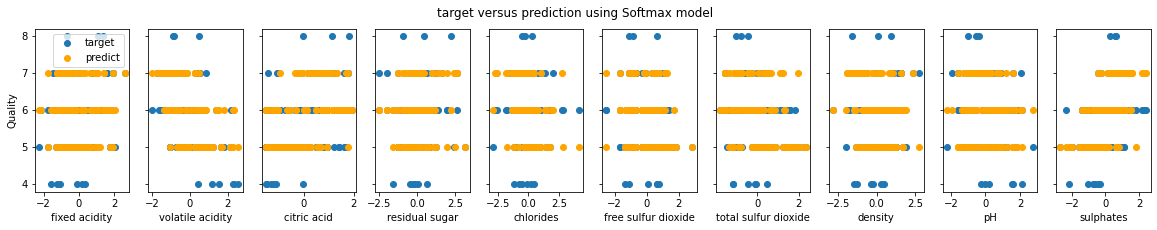

In [82]:
#predict target using normalized features
m = X_test.shape[0]
yp = np.zeros(m)
for loop in range(len(X_test)):
    tabProbas=np.dot(W,X_test[loop])+B
    tabProbas=sigmoid(tabProbas)
    tabProbas=tabProbas/np.sum(tabProbas)
    yp[loop]=locateMax(tabProbas)

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(20, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_test[:,i]],y_test, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_test[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using Softmax model")
plt.show()
